In [10]:
from gen_data import *
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

In [11]:
# Here we define our model as a class
class LSTM(nn.Module):

    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
        
                
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (h, c), where h and c both 
        # have shape (num_layers, batch_size, hidden_dim).
        
        lstm_out, self.hidden = self.lstm(input)
        # print(lstm_out.shape)
        #print (self.lstm.weight_ih_l0)
        
        y_pred = self.linear(lstm_out.view(-1, self.hidden_dim))

        return y_pred


In [12]:
#####################
# Generate data
#####################
task = Add_Task(6, 10, deterministic=True, tau_task=1)
data = task.gen_data(20000, 10000)
X_train_a = data['train']['X']
y_train_a = data['train']['Y']#[:,0]
X_test_a = data['test']['X']
y_test_a = data['train']['Y']#[:,0]

# make training and test sets in torch
X_train = torch.from_numpy(X_train_a).type(torch.Tensor)
X_test = torch.from_numpy(X_test_a).type(torch.Tensor)
y_train = torch.from_numpy(y_train_a).type(torch.Tensor)
y_test = torch.from_numpy(y_test_a).type(torch.Tensor)


In [13]:
#####################
# Set parameters
#####################
# Data params

# Network params
input_size = 2
batch_size = 1
# size of hidden layers
hidden_dim = 32
output_dim = 2
num_layers = 1
learning_rate = 0.01
num_epochs = 50
dtype = torch.float

X_train = X_train.view([-1, batch_size, input_size])
X_test = X_test.view([-1, batch_size, input_size])


In [20]:
def cross_entropy(pred, soft_targets):
    logsoftmax = nn.LogSoftmax(dim=1)
    return torch.mean(torch.sum(-soft_targets * logsoftmax(pred),1))

In [30]:
#####################
# Build model
#####################

model = LSTM(input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
T = 500
#####################
# Train model
#####################

hist = np.zeros(num_epochs)

for t in range(num_epochs):
    
    model.hidden = model.init_hidden()
    # Forward pass
    for i in range(40):
        X_train_s = X_train[i*T:(i+1)*T]
        y_train_s = y_train[i*T:(i+1)*T]
        y_pred = model(X_train_s)
        loss = cross_entropy(y_pred, y_train_s)

        # Zero out gradient, else they will accumulate between epochs
        optimizer.zero_grad()
        loss.backward()
        # Update parameters
        optimizer.step()
        
    if t % 10 == 0:
        print("Epoch ", t, "CE: ", loss.item())
    hist[t] = loss.item()



Epoch  0 CE:  0.6624791026115417
Epoch  10 CE:  0.6609373688697815
Epoch  20 CE:  0.6609200239181519
Epoch  30 CE:  0.6609101295471191
Epoch  40 CE:  0.6609002351760864


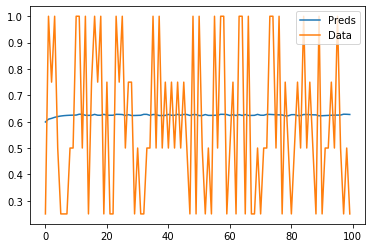

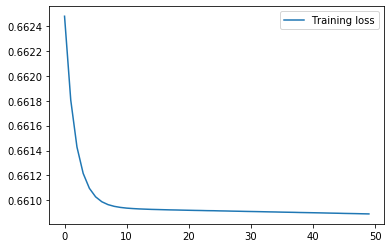

In [31]:
#####################
# Plot preds and performance
#####################
softmax = nn.Softmax(dim=1)
y_prob = softmax(y_pred)
plt.plot(y_prob.detach().numpy()[:100,0],label="Preds")
plt.plot(y_train.detach().numpy()[:100,0],label="Data")
plt.legend()
plt.show()

plt.plot(hist, label="Training loss")
plt.legend()
plt.show()


In [18]:
net = nn.LSTM(100, 100) #Assume only one layer
w_ii, w_if, w_ic, w_io = net.weight_ih_l0.chunk(4, 0)
w_hi, w_hf, w_hc, w_ho = net.weight_hh_l0.chunk(4, 0)
